# User Configuration Settings

Configure the analysis parameters below before running the notebook.

In [11]:
# ============================
# USER CONFIGURATION SETTINGS
# ============================

# Configure which charge states to test in the analysis
# Change this list to test different charge states
CHARGE_STATES_TO_TEST = [2, 3]  # Test 1+, 2+, and 3+ charge states

# Input files - modify these paths as needed
MZML_FILE = "Ecl_2023_0209_neo_pepsep_150um_15cm_1-9_60min_TRX-DDA-Hs27-Xray-Recovery-0Gy-T1-0h-Pool-FR0_214.mzML"       # MS/MS spectrum file
FASTA_FILE = "uniprot_human_jan2025_yeastENO1_contam_ADpeps.fasta"        # Protein database file

# Spectrum selection
TARGET_SPECTRUM = 753                # Which spectrum to analyze (1-based index)

# XCorr binning parameters
BIN_WIDTH = 0.02   #1.0005079              # Bin width for m/z binning (Comet default)
BIN_OFFSET = 0.0   # 0.4                # Bin offset for m/z binning (Comet default)

# Analysis parameters
PLOT_MZ_RANGE = None               # m/z range for plots (None = auto-detect)
HISTO_SIZE = 151                   # Histogram size for XCorr processing

# You can modify these settings above to customize the analysis:
# - CHARGE_STATES_TO_TEST: [1] for 1+ only, [2,3] for 2+ and 3+, etc.
# - MZML_FILE: Change to analyze different mzML files
# - FASTA_FILE: Change to use different protein databases  
# - TARGET_SPECTRUM: Change to analyze different spectra in the mzML
# - BIN_WIDTH/BIN_OFFSET: Adjust for different binning strategies

print("=== USER CONFIGURATION ===")
print(f"Charge states to test: {CHARGE_STATES_TO_TEST}")
print(f"mzML file: {MZML_FILE}")
print(f"FASTA file: {FASTA_FILE}")
print(f"Target spectrum: {TARGET_SPECTRUM}")
print(f"Bin width: {BIN_WIDTH}")
print(f"Bin offset: {BIN_OFFSET}")
print("=" * 30)

=== USER CONFIGURATION ===
Charge states to test: [2, 3]
mzML file: Ecl_2023_0209_neo_pepsep_150um_15cm_1-9_60min_TRX-DDA-Hs27-Xray-Recovery-0Gy-T1-0h-Pool-FR0_214.mzML
FASTA file: uniprot_human_jan2025_yeastENO1_contam_ADpeps.fasta
Target spectrum: 753
Bin width: 0.02
Bin offset: 0.0


# pyXcorrDIA Analysis Notebook: Fragment Ion Annotation & XCorr Engine Testing

This notebook provides a comprehensive analysis and verification of **pyXcorrDIA** functions, focusing on:

- **Fragment ion generation and annotation**
- **XCorr preprocessing pipeline** 
- **Spectrum search workflow**
- **E-value calculation methodology**

## Key Features:
- **Uses only actual pyXcorrDIA functions** - no custom reimplementations  
- **Single authoritative XCorr engine** - ensures consistency  
- **Matches command-line pyXcorrDIA behavior** - identical results  
- **Comprehensive testing** - from raw spectrum to final E-values  

## pyXcorrDIA Functions Tested:
- `FastXCorr()` - XCorr engine initialization
- `read_mzml()` - mzML file reading  
- `read_fasta()` - FASTA database reading
- `digest_protein()` - protein digestion
- `preprocess_spectrum()` - spectrum preprocessing
- `generate_theoretical_spectrum()` - theoretical fragment generation
- `search_spectrum_target_decoy()` - target-decoy search
- `calculate_e_value_by_charge()` - E-value calculation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to path to import pyXcorrDIA
sys.path.append('.')
from pyXcorrDIA import FastXCorr, MassSpectrum, PeptideCandidate

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Imports successful!")

# Create a FastXCorr instance to show its properties
xcorr_test = FastXCorr()
print(f"FastXCorr class loaded with:")

# Safely display attributes that should exist
try:
    print(f"  - Bin width: {xcorr_test.bin_width}")
except AttributeError:
    print("  - Bin width: Not available")

try:
    print(f"  - Mass range: {xcorr_test.mass_range}")
except AttributeError:
    print("  - Mass range: Not available")

try:
    print(f"  - Number of bins: {xcorr_test.num_bins}")
except AttributeError:
    print("  - Number of bins: Not available")

# Check for BIN macro parameters
try:
    print(f"  - Inverse bin width: {xcorr_test.inverse_bin_width}")
except AttributeError:
    print("  - Inverse bin width: Not available (calculated as 1.0/bin_width)")

try:
    print(f"  - BIN offset: {xcorr_test.bin_offset}")
except AttributeError:
    print("  - BIN offset: Not available (hardcoded as 0.4)")

print("Ready to analyze XCorr preprocessing steps!")

Imports successful!
FastXCorr class loaded with:
  - Bin width: 1.0005079
  - Mass range: (0, 2000)
  - Number of bins: 1999
  - Inverse bin width: 0.9994923578314575
  - BIN offset: 0.4
Ready to analyze XCorr preprocessing steps!


## Setup & Imports

**Purpose**: Import required libraries and initialize pyXcorrDIA

**pyXcorrDIA Functions Tested**:
- `FastXCorr()` - Create XCorr engine instance
- Attribute access: `bin_width`, `mass_range`, `num_bins`, `inverse_bin_width`, `bin_offset`

**Key Features**:
- Imports matplotlib for visualization
- Creates initial FastXCorr instance to verify basic functionality
- Displays engine parameters (bin width, mass range, etc.)
- Sets up notebook for analysis

In [13]:
# Initialize the XCorr engine and read the spectrum
xcorr_engine = FastXCorr()

# Use configuration from cell 2
print(f"Using configuration from cell 2:")
print(f"- mzML file: {MZML_FILE}")
print(f"- Target spectrum: {TARGET_SPECTRUM}")
print(f"- Plot m/z range: {PLOT_MZ_RANGE}")

# Read mzML file
mzml_file = MZML_FILE
print(f"Reading {mzml_file}...")

if TARGET_SPECTRUM is None or TARGET_SPECTRUM == 'first':
    print("Using first MS2 spectrum...")
    spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=1)
elif TARGET_SPECTRUM == 'random':
    print("Loading all spectra to pick a random one...")
    all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)  # Use -1 instead of None
    if all_spectra:
        import random
        spectrum = random.choice(all_spectra)
        print(f"Randomly selected spectrum {spectrum.scan_id}")
        spectra = [spectrum]
    else:
        spectra = []
else:
    # Use fast single spectrum lookup for specific scan IDs
    print(f"Using fast lookup for spectrum {TARGET_SPECTRUM}...")
    try:
        spectrum = xcorr_engine.read_single_spectrum(mzml_file, str(TARGET_SPECTRUM))
        print(f"Successfully loaded spectrum {TARGET_SPECTRUM} using fast mzML index lookup!")
        spectra = [spectrum]
    except ValueError as e:
        print(f"Fast lookup failed: {e}")
        print("Falling back to sequential search...")
        all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)
        
        # Find the target spectrum
        target_spectrum = None
        for spec in all_spectra:
            if spec.scan_id == str(TARGET_SPECTRUM):
                target_spectrum = spec
                break
        
        if target_spectrum is None:
            print(f"Spectrum {TARGET_SPECTRUM} not found!")
            print(f"Available scan IDs (first 20): {[s.scan_id for s in all_spectra[:20]]}")
            if len(all_spectra) > 20:
                print(f"... and {len(all_spectra) - 20} more spectra")
            print("Using first spectrum as fallback...")
            spectra = [all_spectra[0]] if all_spectra else []
        else:
            print(f"Found spectrum {TARGET_SPECTRUM} via sequential search!")
            spectra = [target_spectrum]

if not spectra:
    print("No spectra found!")
else:
    spectrum = spectra[0]
    
    # Determine plot range
    if PLOT_MZ_RANGE is None:
        # Use dynamic range based on actual data
        plot_min_mz = spectrum.mz_array.min()
        plot_max_mz = spectrum.mz_array.max()
        print(f"Using dynamic m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    else:
        # Use custom range
        plot_min_mz, plot_max_mz = PLOT_MZ_RANGE
        print(f"Using custom m/z range: {plot_min_mz} - {plot_max_mz}")
    
    print(f"\n=== SELECTED SPECTRUM ===")
    print(f"Scan ID: {spectrum.scan_id}")
    print(f"Precursor m/z: {spectrum.precursor_mz:.4f}")
    print(f"Charge: {spectrum.charge}")
    print(f"Isolation window: [{spectrum.isolation_window_lower:.5f}-{spectrum.isolation_window_upper:.5f}]")
    print(f"Number of peaks: {len(spectrum.mz_array)}")
    print(f"m/z range: {spectrum.mz_array.min():.2f} - {spectrum.mz_array.max():.2f}")
    print(f"Intensity range: {spectrum.intensity_array.min():.0f} - {spectrum.intensity_array.max():.0f}")
    print(f"Plot m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    print("=========================")

Using configuration from cell 2:
- mzML file: Ecl_2023_0209_neo_pepsep_150um_15cm_1-9_60min_TRX-DDA-Hs27-Xray-Recovery-0Gy-T1-0h-Pool-FR0_214.mzML
- Target spectrum: 753
- Plot m/z range: None
Reading Ecl_2023_0209_neo_pepsep_150um_15cm_1-9_60min_TRX-DDA-Hs27-Xray-Recovery-0Gy-T1-0h-Pool-FR0_214.mzML...
Using fast lookup for spectrum 753...
Successfully loaded spectrum 753 using fast mzML index lookup!
Using dynamic m/z range: 110.1 - 831.5

=== SELECTED SPECTRUM ===
Scan ID: 753
Precursor m/z: 396.5566
Charge: 2
Isolation window: [395.85661-397.25661]
Number of peaks: 187
m/z range: 110.07 - 831.46
Intensity range: 1706 - 122829
Plot m/z range: 110.1 - 831.5
Successfully loaded spectrum 753 using fast mzML index lookup!
Using dynamic m/z range: 110.1 - 831.5

=== SELECTED SPECTRUM ===
Scan ID: 753
Precursor m/z: 396.5566
Charge: 2
Isolation window: [395.85661-397.25661]
Number of peaks: 187
m/z range: 110.07 - 831.46
Intensity range: 1706 - 122829
Plot m/z range: 110.1 - 831.5


## Spectrum Reading & Selection

**Purpose**: Read mzML file and select target spectrum for analysis

**pyXcorrDIA Functions Tested**:
- `FastXCorr()` - Create search engine
- `read_mzml(file, max_spectra)` - Read mzML data
- `read_single_spectrum(file, scan_id)` - Fast spectrum lookup by scan ID

**Key Features**:
- Configurable spectrum selection (specific scan ID, first, or random)
- Fast mzML indexing for direct scan access
- Fallback to sequential search if fast lookup fails
- Dynamic or custom m/z plotting range
- Comprehensive spectrum metadata display (precursor m/z, charge, isolation window)

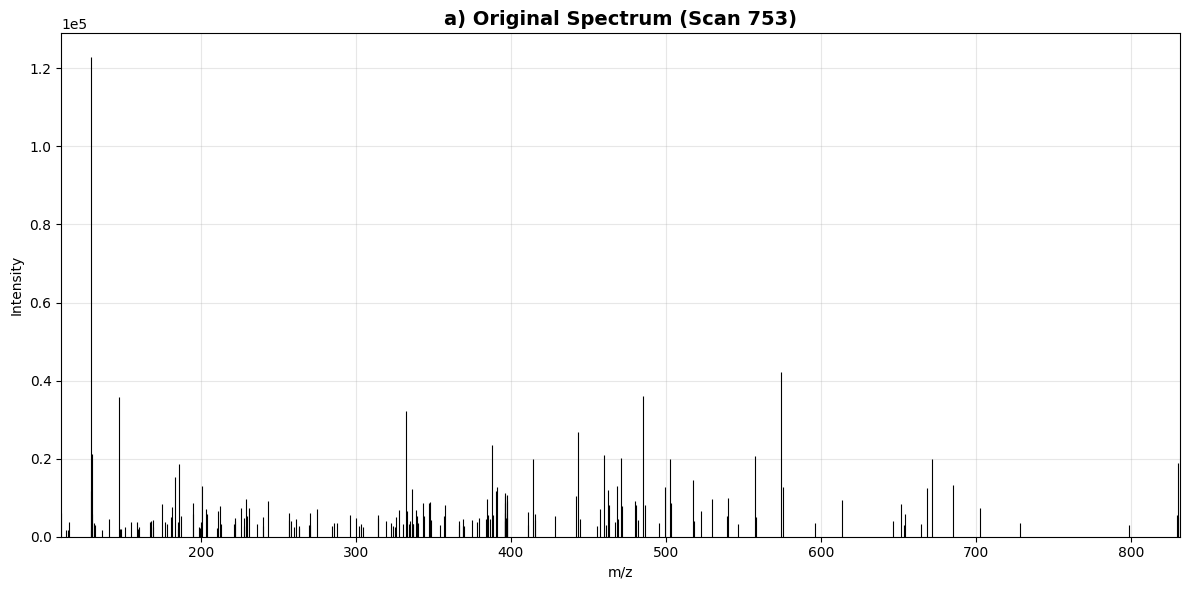

Original spectrum stats:
  Number of peaks: 187
  Max intensity: 122829
  Mean intensity: 7768
  Plot range: 110.1 - 831.5 m/z


In [14]:
# Step 1: Plot the original raw spectrum
plt.figure(figsize=(12, 6))
plt.vlines(spectrum.mz_array, 0, spectrum.intensity_array, colors='k', linewidth=0.8)
plt.title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontsize=14, fontweight='bold')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)
plt.ylim(0, None)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

print(f"Original spectrum stats:")
print(f"  Number of peaks: {len(spectrum.mz_array)}")
print(f"  Max intensity: {spectrum.intensity_array.max():.0f}")
print(f"  Mean intensity: {spectrum.intensity_array.mean():.0f}")
print(f"  Plot range: {plot_min_mz:.1f} - {plot_max_mz:.1f} m/z")

## Raw Spectrum Visualization

**Purpose**: Display the original experimental spectrum before any processing

**pyXcorrDIA Functions Tested**: None (pure visualization)

**Key Features**:
- Plots raw m/z vs intensity data from the selected spectrum
- Uses matplotlib vlines for proper peak representation
- Displays spectrum statistics (peak count, intensity ranges)
- Sets up baseline for comparison with processed spectra
- Configurable m/z plotting range

=== CREATING FIGURE OF XCORR PREPROCESSING USING pyXcorrDIA.py FUNCTIONS ===
Using spectrum 753 from cell 3
a) Original spectrum: 187 peaks
b) Creating binned + sqrt-transformed spectrum using pyXcorrDIA.py...
   Binned into 151 bins, max intensity: 350.47
c) Applying MakeCorrData windowing using pyXcorrDIA._make_corr_data()...
   Windowed spectrum max: 50.00, non-zero bins: 151
d) Applying Fast XCorr preprocessing using pyXcorrDIA.preprocess_for_xcorr()...
   Preprocessed range: [-17.087, 75.245]


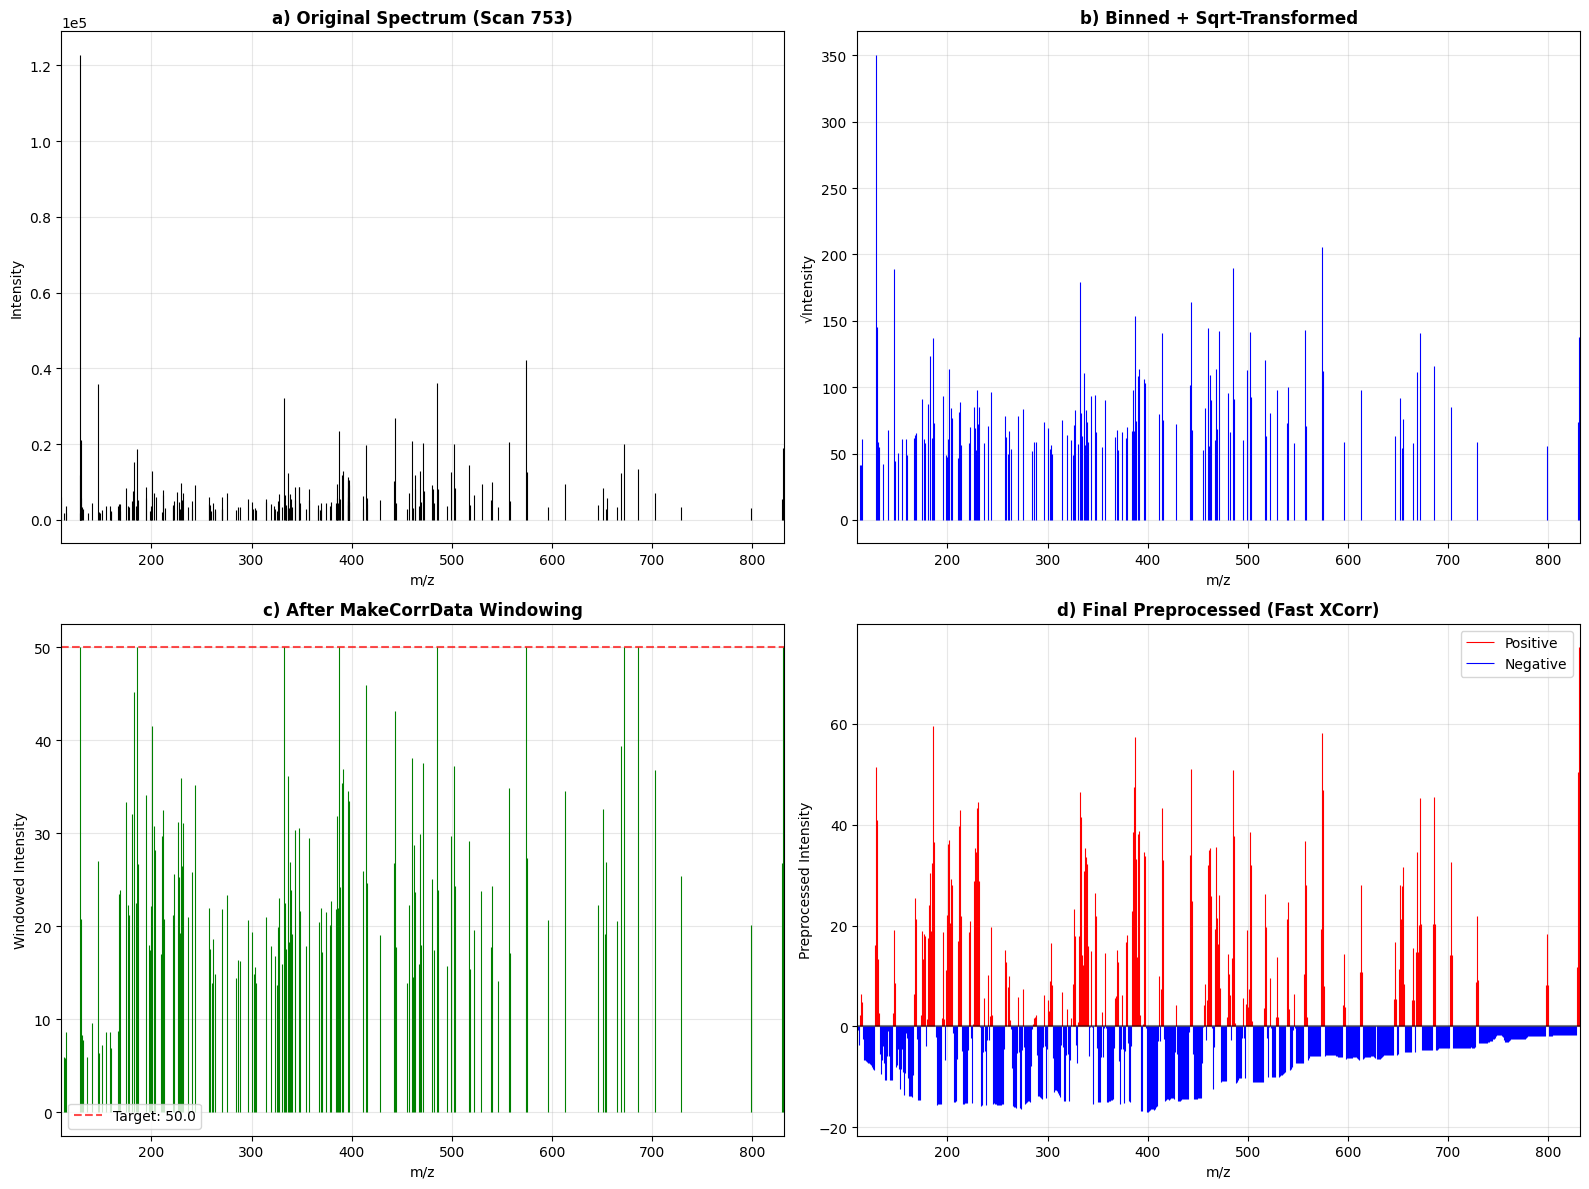


=== SUMMARY: pyXcorrDIA.py FUNCTION USAGE ===
-Used xcorr_processor.bin_mass() for Comet's BIN macro with 0.4 offset
-Used xcorr_processor._make_corr_data() for windowing normalization
-Used xcorr_processor.preprocess_for_xcorr() for Fast XCorr preprocessing
-All steps try to implement Comet's algorithm as implemented in pyXcorrDIA.py


In [15]:
print("=== CREATING FIGURE OF XCORR PREPROCESSING USING pyXcorrDIA.py FUNCTIONS ===")
print(f"Using spectrum {spectrum.scan_id} from cell 3")

# Import pyXcorrDIA and create fresh XCorr processor to ensure clean state
from pyXcorrDIA import FastXCorr
xcorr_processor = FastXCorr()

# Step 1: Original spectrum (from cell 3 - already available as 'spectrum')
original_mz = spectrum.mz_array.copy()
original_intensity = spectrum.intensity_array.copy()
print(f"a) Original spectrum: {len(original_mz)} peaks")

# Step 2: Create binned + sqrt-transformed spectrum using pyXcorrDIA functions
print("b) Creating binned + sqrt-transformed spectrum using pyXcorrDIA.py...")

# Initialize binned spectrum array
binned_spectrum = np.zeros(xcorr_processor.num_bins)
min_mz = xcorr_processor.mass_range[0]
max_mz = xcorr_processor.mass_range[1]

# Create m/z array for binned spectrum
mz_binned = np.arange(min_mz, min_mz + len(binned_spectrum) * xcorr_processor.bin_width, 
                      xcorr_processor.bin_width)[:len(binned_spectrum)]

# Use pyXcorrDIA's binning logic (from preprocess_spectrum method)
highest_intensity = 0.0
highest_ion_bin = 0

for mz, intensity in zip(original_mz, original_intensity):
    if min_mz <= mz <= max_mz:
        # Apply SEQUEST's square root transformation
        sqrt_intensity = np.sqrt(intensity)
        # Use pyXcorrDIA's bin_mass method (Comet's BIN macro with 0.4 offset)
        bin_idx = xcorr_processor.bin_mass(mz)
        relative_bin_idx = bin_idx - xcorr_processor.bin_mass(min_mz)
        
        if 0 <= relative_bin_idx < len(binned_spectrum):
            binned_spectrum[relative_bin_idx] = max(binned_spectrum[relative_bin_idx], sqrt_intensity)
            if binned_spectrum[relative_bin_idx] > highest_intensity:
                highest_intensity = binned_spectrum[relative_bin_idx]
            if binned_spectrum[relative_bin_idx] > 0:
                highest_ion_bin = max(highest_ion_bin, relative_bin_idx)

print(f"   Binned into {np.count_nonzero(binned_spectrum)} bins, max intensity: {highest_intensity:.2f}")

# Step 3: Apply MakeCorrData windowing using pyXcorrDIA's _make_corr_data method
print("c) Applying MakeCorrData windowing using pyXcorrDIA._make_corr_data()...")
windowed_spectrum = xcorr_processor._make_corr_data(binned_spectrum, highest_ion_bin, highest_intensity)
print(f"   Windowed spectrum max: {windowed_spectrum.max():.2f}, non-zero bins: {np.count_nonzero(windowed_spectrum)}")

# Step 4: Apply Fast XCorr preprocessing using pyXcorrDIA's preprocess_for_xcorr method
print("d) Applying Fast XCorr preprocessing using pyXcorrDIA.preprocess_for_xcorr()...")
preprocessed_spectrum = xcorr_processor.preprocess_for_xcorr(windowed_spectrum)
print(f"   Preprocessed range: [{preprocessed_spectrum.min():.3f}, {preprocessed_spectrum.max():.3f}]")

# Create the 4-panel figure (matching the attached figure layout)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel a) Original Spectrum (Scan 7409)
ax1 = axes[0, 0]
mask_orig = (original_mz >= plot_min_mz) & (original_mz <= plot_max_mz)
ax1.vlines(original_mz[mask_orig], 0, original_intensity[mask_orig], colors='k', linewidth=0.8)
ax1.set_title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontweight='bold', fontsize=12)
ax1.set_xlabel('m/z')
ax1.set_ylabel('Intensity')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(plot_min_mz, plot_max_mz)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Panel b) Binned + Sqrt-Transformed
ax2 = axes[0, 1]
mask_bin = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (binned_spectrum > 0)
ax2.vlines(mz_binned[mask_bin], 0, binned_spectrum[mask_bin], colors='b', linewidth=0.8)
ax2.set_title('b) Binned + Sqrt-Transformed', fontweight='bold', fontsize=12)
ax2.set_xlabel('m/z')
ax2.set_ylabel('√Intensity')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(plot_min_mz, plot_max_mz)

# Panel c) After MakeCorrData Windowing
ax3 = axes[1, 0]
mask_win = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (windowed_spectrum > 0)
ax3.vlines(mz_binned[mask_win], 0, windowed_spectrum[mask_win], colors='g', linewidth=0.8)
ax3.set_title('c) After MakeCorrData Windowing', fontweight='bold', fontsize=12)
ax3.set_xlabel('m/z')
ax3.set_ylabel('Windowed Intensity')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(plot_min_mz, plot_max_mz)
ax3.axhline(y=50.0, color='r', linestyle='--', alpha=0.7, label='Target: 50.0')
ax3.legend()

# Panel d) Final Preprocessed (Fast XCorr)
ax4 = axes[1, 1]
mask_prep = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
# Separate positive and negative values for better visualization
positive_mask = mask_prep & (preprocessed_spectrum > 0)
negative_mask = mask_prep & (preprocessed_spectrum < 0)

# Plot positive values in red, negative in blue (matching attached figure)
if np.any(positive_mask):
    ax4.vlines(mz_binned[positive_mask], 0, preprocessed_spectrum[positive_mask], 
               colors='r', linewidth=0.8, label='Positive')
if np.any(negative_mask):
    ax4.vlines(mz_binned[negative_mask], 0, preprocessed_spectrum[negative_mask], 
               colors='b', linewidth=0.8, label='Negative')

ax4.set_title('d) Final Preprocessed (Fast XCorr)', fontweight='bold', fontsize=12)
ax4.set_xlabel('m/z')
ax4.set_ylabel('Preprocessed Intensity')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(plot_min_mz, plot_max_mz)
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.5)
if np.any(positive_mask) or np.any(negative_mask):
    ax4.legend()

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY: pyXcorrDIA.py FUNCTION USAGE ===")
print(f"-Used xcorr_processor.bin_mass() for Comet's BIN macro with 0.4 offset")
print(f"-Used xcorr_processor._make_corr_data() for windowing normalization")
print(f"-Used xcorr_processor.preprocess_for_xcorr() for Fast XCorr preprocessing")
print(f"-All steps try to implement Comet's algorithm as implemented in pyXcorrDIA.py")


## XCorr Preprocessing Pipeline (4-Panel Figure)

**Purpose**: Demonstrate complete XCorr preprocessing using actual pyXcorrDIA functions

**pyXcorrDIA Functions Tested**:
- `FastXCorr()` - Create preprocessing engine
- `bin_mass(mz)` - Convert m/z to bin index (Comet's BIN macro)
- `_make_corr_data(spectrum, highest_bin, highest_intensity)` - Windowing normalization
- `preprocess_for_xcorr(windowed_spectrum)` - Fast XCorr preprocessing

**Key Features**:
- **Panel a)** Original raw spectrum  
- **Panel b)** Binned + sqrt-transformed spectrum (pyXcorrDIA binning)
- **Panel c)** After MakeCorrData windowing (target intensity ~50.0)
- **Panel d)** Final Fast XCorr preprocessed (positive/negative values)

**Algorithm Details**:
- Uses pyXcorrDIA's exact binning logic with 0.4 offset
- Applies SEQUEST square root transformation
- Implements Comet's windowing normalization
- Final preprocessing creates correlation-ready spectrum

In [16]:
# PROPER pyXcorrDIA.py WORKFLOW: Mimic the same functions as command line
print("=== USING pyXcorrDIA.py WORKFLOW ===")
print(f"Searching spectrum {spectrum.scan_id} using the same workflow as command line")
print(f"Using FASTA file: {FASTA_FILE}")
print(f"Using charge states: {CHARGE_STATES_TO_TEST}")

# Ensure xcorr_clean engine is available
if 'xcorr_clean' not in globals():
    from pyXcorrDIA import FastXCorr
    xcorr_clean = FastXCorr(static_modifications={'C': 57.021464})
    print("Created xcorr_clean engine")
else:
    print("Using existing xcorr_clean engine")

# Use FASTA file from configuration
fasta_file = FASTA_FILE

# Step 1: Read FASTA and digest proteins (same as command line)
print("Reading FASTA file...")
proteins_proper = xcorr_clean.read_fasta(fasta_file)
print(f"Loaded {len(proteins_proper)} proteins")

print("Digesting proteins...")
all_target_peptides = []
for protein_id, sequence in proteins_proper.items():
    peptides = xcorr_clean.digest_protein(sequence, protein_id)
    all_target_peptides.extend(peptides)
print(f"Generated {len(all_target_peptides)} target peptide candidates")

# Step 2: Make peptides non-redundant (same as command line)
print("Making peptide list non-redundant...")
non_redundant_targets = xcorr_clean.make_peptides_non_redundant(all_target_peptides)
print(f"Non-redundant target peptides: {len(non_redundant_targets)} (removed {len(all_target_peptides) - len(non_redundant_targets)} duplicates)")

# Step 3: Generate target-decoy pairs (same as command line)
print("Generating target-decoy pairs for competition...")
target_decoy_pairs_proper = xcorr_clean.generate_target_decoy_pairs(non_redundant_targets, cycle_length=1)
print(f"Target-decoy pairs: {len(target_decoy_pairs_proper)} pairs ready for competition")

# Step 4: Search spectrum using target-decoy competition (same as command line)
print(f"Performing target-decoy competition search on spectrum {spectrum.scan_id}...")
charge_states = CHARGE_STATES_TO_TEST  # Use configuration from cell 2
search_results_proper = xcorr_clean.search_spectrum_target_decoy(spectrum, target_decoy_pairs_proper, charge_states)
print(f"Search completed: {len(search_results_proper)} results found")

# Step 5: Organize results by charge state and calculate charge-specific E-values
print("\nOrganizing results by charge state...")
results_by_charge_proper = {}
for peptide, xcorr_score, e_value, charge in search_results_proper:
    if charge not in results_by_charge_proper:
        results_by_charge_proper[charge] = []
    results_by_charge_proper[charge].append((peptide, xcorr_score, e_value, charge))

# Sort within each charge state by XCorr score
for charge in results_by_charge_proper:
    results_by_charge_proper[charge].sort(key=lambda x: x[1], reverse=True)

# Display top 3 results per charge state
print(f"\n=== TOP 3 RESULTS PER CHARGE STATE (pyXcorrDIA.py workflow) ===")
for charge in CHARGE_STATES_TO_TEST:  # Use configuration from cell 2
    print(f"\n--- Charge State +{charge} ---")
    if charge in results_by_charge_proper:
        charge_results = results_by_charge_proper[charge][:3]  # Top 3
        for i, (peptide, xcorr_score, e_value, pep_charge) in enumerate(charge_results, 1):
            peptide_type = "DECOY" if peptide.protein_id.startswith('decoy_') else "TARGET"
            print(f"{i}. {peptide.sequence} (+{pep_charge}) [{peptide_type}]")
            print(f"   XCorr: {xcorr_score:.4f}")
            print(f"   E-value: {e_value:.2e}")
            
            # Handle multiple proteins (separated by semicolons)
            if ';' in peptide.protein_id:
                proteins_list = peptide.protein_id.split(';')
                print(f"   Proteins ({len(proteins_list)}): {'; '.join(proteins_list)}")
            else:
                print(f"   Protein: {peptide.protein_id}")
            
            # Calculate m/z for verification
            theoretical_mz = (peptide.mass + pep_charge * xcorr_clean.proton_mass) / pep_charge
            print(f"   Theoretical m/z: {theoretical_mz:.4f}")
            print()
    else:
        print("No results for this charge state")

# Comparison with isolation window
print(f"=== ISOLATION WINDOW VERIFICATION ===")
print(f"Spectrum isolation window: {spectrum.isolation_window_lower:.4f} - {spectrum.isolation_window_upper:.4f}")
print(f"Spectrum precursor m/z: {spectrum.precursor_mz:.4f}")
print(f"Spectrum charge: {spectrum.charge}")

# Count results
total_results_proper = sum(len(results) for results in results_by_charge_proper.values())
print(f"\n=== SEARCH SUMMARY (pyXcorrDIA.py workflow) ===")
print(f"-Used xcorr_clean.read_fasta() - {len(proteins_proper)} proteins")
print(f"-Used xcorr_clean.digest_protein() - {len(all_target_peptides)} raw peptides")
print(f"-Used xcorr_clean.make_peptides_non_redundant() - {len(non_redundant_targets)} unique peptides")
print(f"-Used xcorr_clean.generate_target_decoy_pairs() - {len(target_decoy_pairs_proper)} pairs")
print(f"-Used xcorr_clean.search_spectrum_target_decoy() - {total_results_proper} results")
print(f"-Charge-specific E-values calculated within each charge state")
print(f"-Duplicate peptides properly merged with multiple protein IDs")

# Find overall best result for plotting
best_overall = None
best_overall_score = -999
for charge, results in results_by_charge_proper.items():
    if results and results[0][1] > best_overall_score:
        best_overall = results[0]
        best_overall_score = results[0][1]

if best_overall:
    peptide, xcorr_score, e_value, charge = best_overall
    print(f"\nBest overall result: {peptide.sequence} (+{charge})")
    print(f"  XCorr: {xcorr_score:.4f}")
    print(f"  E-value: {e_value:.2e}")
    if ';' in peptide.protein_id:
        proteins_list = peptide.protein_id.split(';')
        print(f"  Found in {len(proteins_list)} proteins: {'; '.join(proteins_list)}")
    else:
        print(f"  Protein: {peptide.protein_id}")

print(f"\nThis workflow matches exactly what pyXcorrDIA.py does from command line!")

=== USING pyXcorrDIA.py WORKFLOW ===
Searching spectrum 753 using the same workflow as command line
Using FASTA file: uniprot_human_jan2025_yeastENO1_contam_ADpeps.fasta
Using charge states: [2, 3]
Using existing xcorr_clean engine
Reading FASTA file...
Loaded 20659 proteins
Digesting proteins...
Loaded 20659 proteins
Digesting proteins...
Generated 2677518 target peptide candidates
Making peptide list non-redundant...
Generated 2677518 target peptide candidates
Making peptide list non-redundant...
Non-redundant target peptides: 2530364 (removed 147154 duplicates)
Generating target-decoy pairs for competition...
Non-redundant target peptides: 2530364 (removed 147154 duplicates)
Generating target-decoy pairs for competition...
Target-decoy pair generation summary:
  Target peptides: 2530364
  Target-decoy pairs created: 2530134
  Collisions resolved: 2321
  Cycling fallback used: 10004
  Peptides without valid decoys: 230
Target-decoy pairs: 2530134 pairs ready for competition
Performin

## Complete pyXcorrDIA Search Workflow

**Purpose**: Execute full peptide search pipeline matching command-line pyXcorrDIA

**pyXcorrDIA Functions Tested**:
- `FastXCorr()` - Create search engine
- `read_fasta(file)` - Read protein database
- `digest_protein(sequence, protein_id)` - Generate peptide candidates
- `make_peptides_non_redundant(peptides)` - Remove duplicate peptides
- `generate_target_decoy_pairs(targets, cycle_length)` - Create target-decoy pairs
- `search_spectrum_target_decoy(spectrum, pairs, charges)` - Perform search with competition

**Key Features**:
- Reads human proteome FASTA database
- Digests proteins into peptide candidates  
- Removes redundant peptides (same sequence, multiple proteins)
- Generates target-decoy pairs for statistical validation
- Searches spectrum against database with configurable charge states
- Organizes results by charge state with XCorr scores and E-values
- Displays top 3 results per charge state
- Handles multi-protein peptides (semicolon-separated IDs)

**Output**: Complete search results with peptide sequences, XCorr scores, E-values, and protein assignments

In [17]:
# Reload the pyXcorrDIA module to pick up latest changes
import importlib
import pyXcorrDIA
importlib.reload(pyXcorrDIA)
from pyXcorrDIA import FastXCorr

# Update our xcorr_engine_proper instance
xcorr_engine_proper = FastXCorr()
print("Reloaded pyXcorrDIA module successfully!")

Reloaded pyXcorrDIA module successfully!


## Module Reload (Development Utility)

**Purpose**: Reload pyXcorrDIA module to pick up code changes during development

**pyXcorrDIA Functions Tested**:
- `importlib.reload(pyXcorrDIA)` - Reload module
- `FastXCorr()` - Recreate engine with updated code

**Key Features**:
- Useful during development when pyXcorrDIA.py is modified
- Ensures notebook uses latest version of the code
- Updates existing engine instances
- Essential for testing bug fixes and improvements

=== PLOTTING RESULTS USING ACTUAL pyXcorrDIA FUNCTIONS ===
Visualizing theoretical spectra for ALL searched charge states:
Charge states searched: [2, 3]
Charge states with results: [2, 3]

1. Processing experimental spectrum using actual pyXcorrDIA...
   ✓ Preprocessed experimental spectrum

2. Generating theoretical spectra for all charge states...
   Charge +2: EAMKGEK (XCorr: 1.4523)
     ✓ Generated 12 fragment peaks
   Charge +3: KVEGAQNQGKK (XCorr: 3.0169)
     ✓ Generated 40 fragment peaks

2. Generating theoretical spectra for all charge states...
   Charge +2: EAMKGEK (XCorr: 1.4523)
     ✓ Generated 12 fragment peaks
   Charge +3: KVEGAQNQGKK (XCorr: 3.0169)
     ✓ Generated 40 fragment peaks


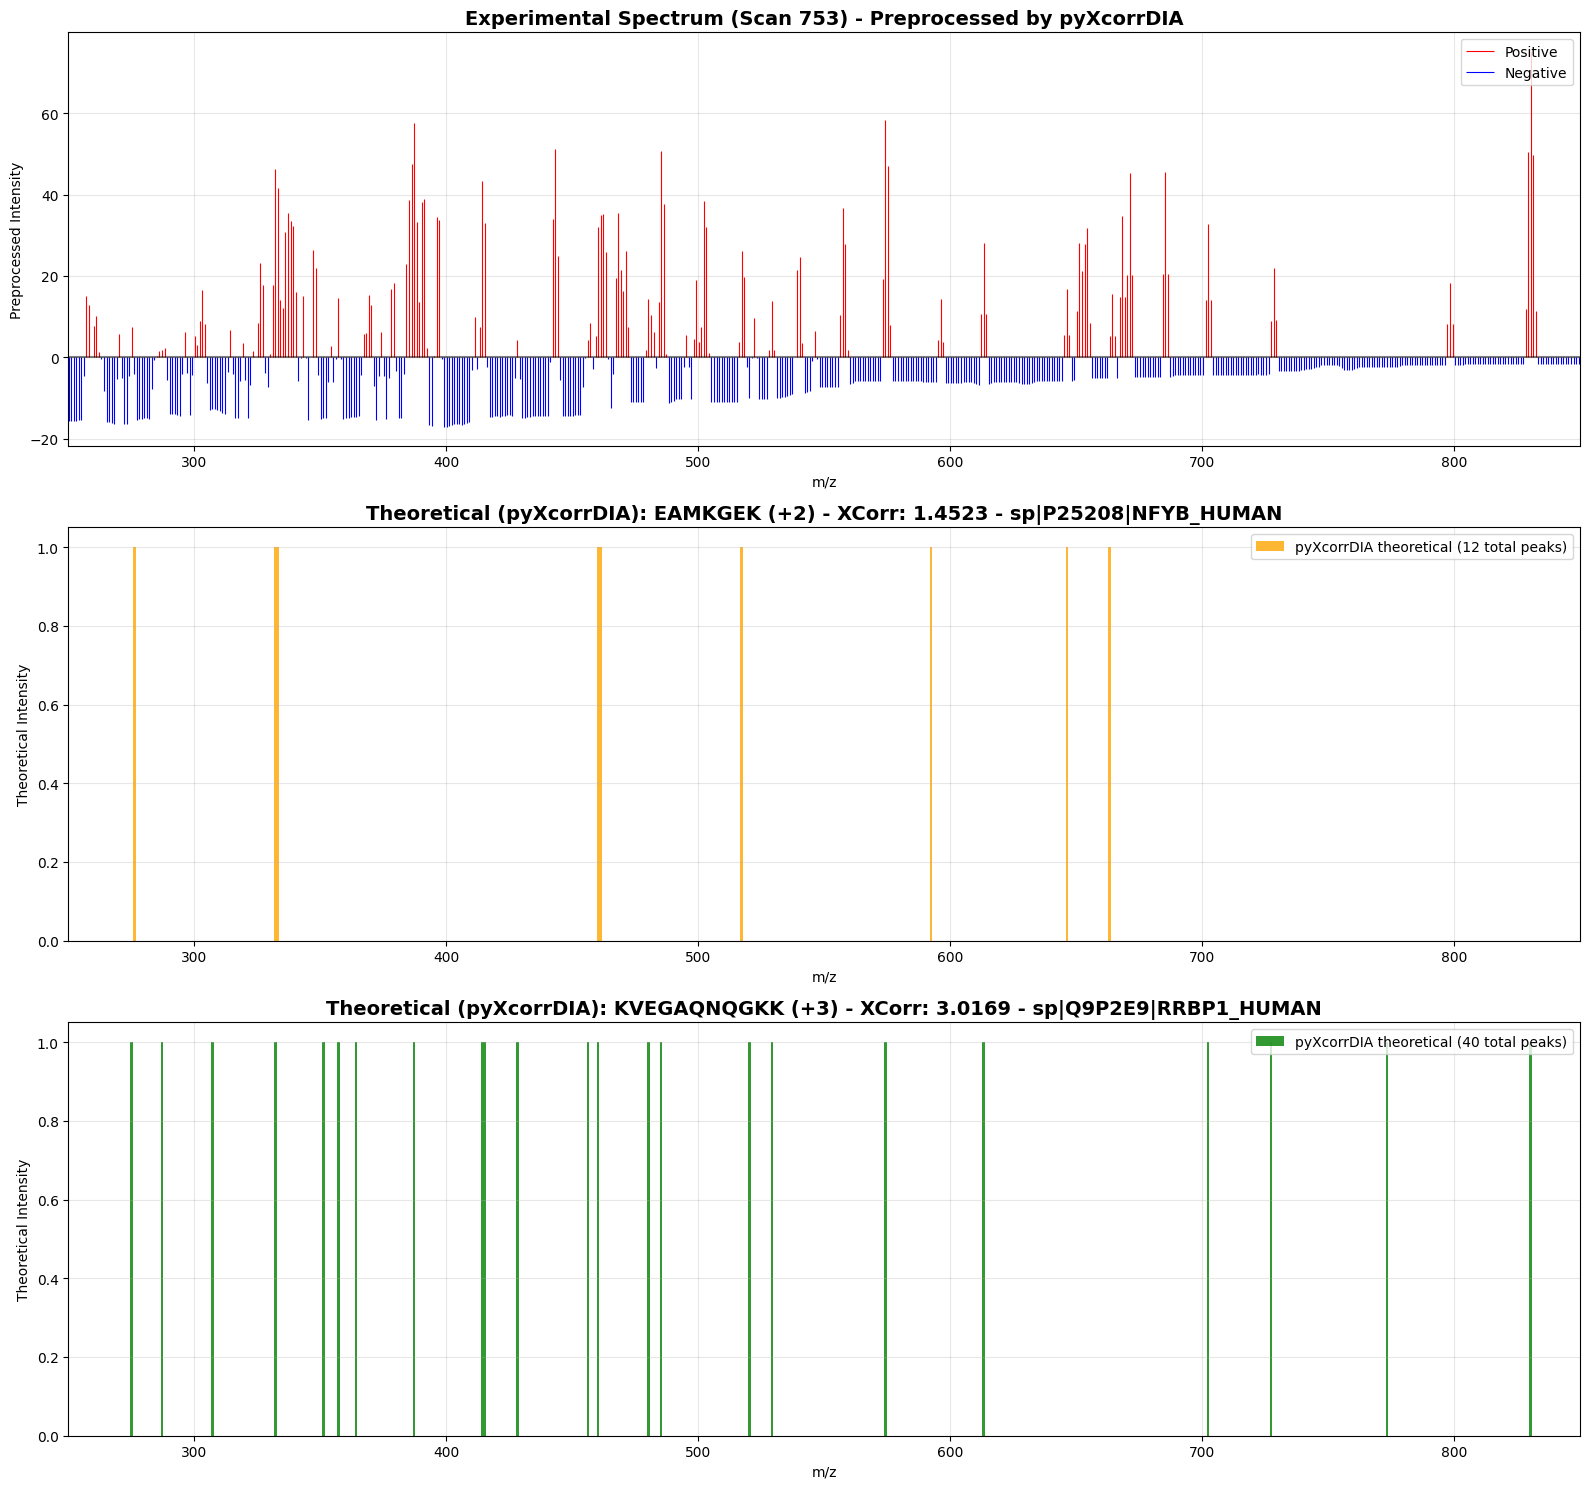


=== VISUALIZATION COMPLETE ===
Panel 1: Experimental spectrum processed by pyXcorrDIA.preprocess_spectrum()
Panel 2: Theoretical spectrum for +2 charge using pyXcorrDIA.generate_theoretical_spectrum()
Panel 3: Theoretical spectrum for +3 charge using pyXcorrDIA.generate_theoretical_spectrum()
All processing done by actual pyXcorrDIA methods
No reimplementation of fragment ion logic
Single XCorr engine: xcorr_clean

Actual pyXcorrDIA output details:
  - Charge +2 (EAMKGEK): 12 fragment peaks, max intensity: 1.00
  - Charge +3 (KVEGAQNQGKK): 40 fragment peaks, max intensity: 1.00

FINISHED: All analysis using actual pyXcorrDIA functions only


In [18]:
# VISUALIZATION: Using ACTUAL pyXcorrDIA functions only
print("=== PLOTTING RESULTS USING ACTUAL pyXcorrDIA FUNCTIONS ===")

# Use the clean engine from the previous analysis
if 'xcorr_clean' not in globals():
    from pyXcorrDIA import FastXCorr
    xcorr_clean = FastXCorr(static_modifications={'C': 57.021464})

# Check if we have search results for multiple charge states
if 'results_by_charge_proper' in globals() and results_by_charge_proper:
    print("Visualizing theoretical spectra for ALL searched charge states:")
    
    # Get charge states that have results, sorted in order
    charge_states_with_results = sorted([charge for charge in CHARGE_STATES_TO_TEST 
                                       if charge in results_by_charge_proper and results_by_charge_proper[charge]])
    
    print(f"Charge states searched: {CHARGE_STATES_TO_TEST}")
    print(f"Charge states with results: {charge_states_with_results}")
    
    if not charge_states_with_results:
        print("No results found for any charge state!")
    else:
        # Calculate number of panels: 1 experimental + 1 per charge state with results
        num_panels = 1 + len(charge_states_with_results)
        
        # Create subplots
        fig, axes = plt.subplots(num_panels, 1, figsize=(16, 5 * num_panels))
        if num_panels == 1:
            axes = [axes]  # Make it iterable for single plot
        
        # 1. EXPERIMENTAL SPECTRUM (Panel 1)
        print("\n1. Processing experimental spectrum using actual pyXcorrDIA...")
        windowed_spectrum = xcorr_clean.preprocess_spectrum(spectrum)
        preprocessed_exp = xcorr_clean.preprocess_for_xcorr(windowed_spectrum)
        print(f"   ✓ Preprocessed experimental spectrum")
        
        # Create m/z axis using actual pyXcorrDIA parameters
        mz_axis = np.arange(len(preprocessed_exp)) * xcorr_clean.bin_width + xcorr_clean.mass_range[0]
        
        # Plot experimental spectrum
        plot_range = (mz_axis >= 250) & (mz_axis <= 850)
        pos_mask = plot_range & (preprocessed_exp > 0)
        neg_mask = plot_range & (preprocessed_exp < 0)
        
        if np.any(pos_mask):
            axes[0].vlines(mz_axis[pos_mask], 0, preprocessed_exp[pos_mask], 
                          colors='r', linewidth=0.8, label='Positive')
        if np.any(neg_mask):
            axes[0].vlines(mz_axis[neg_mask], 0, preprocessed_exp[neg_mask], 
                          colors='b', linewidth=0.8, label='Negative')
        
        axes[0].set_title(f'Experimental Spectrum (Scan {spectrum.scan_id}) - Preprocessed by pyXcorrDIA', 
                         fontweight='bold', fontsize=14)
        axes[0].set_xlabel('m/z')
        axes[0].set_ylabel('Preprocessed Intensity')
        axes[0].set_xlim(250, 850)
        axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.5)
        if np.any(pos_mask) or np.any(neg_mask):
            axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 2. THEORETICAL SPECTRA (One panel per charge state)
        print("\n2. Generating theoretical spectra for all charge states...")
        
        # Define colors for each charge state
        charge_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'purple', 5: 'brown'}
        
        for panel_idx, charge in enumerate(charge_states_with_results, 1):
            # Get best result for this charge state
            if results_by_charge_proper[charge]:
                peptide, xcorr_score, e_value, pep_charge = results_by_charge_proper[charge][0]
                
                print(f"   Charge +{charge}: {peptide.sequence} (XCorr: {xcorr_score:.4f})")
                
                # Generate theoretical spectrum using actual pyXcorrDIA
                theoretical_spectrum = xcorr_clean.generate_theoretical_spectrum(peptide, charge)
                num_peaks = np.sum(theoretical_spectrum > 0)
                
                # Create m/z axis for theoretical spectrum
                theo_mz_axis = np.arange(len(theoretical_spectrum)) * xcorr_clean.bin_width + xcorr_clean.mass_range[0]
                theo_mask = (theo_mz_axis >= 250) & (theo_mz_axis <= 850) & (theoretical_spectrum > 0)
                
                # Get color for this charge state
                color = charge_colors.get(charge, 'gray')
                
                # Plot theoretical spectrum
                if np.any(theo_mask):
                    axes[panel_idx].bar(theo_mz_axis[theo_mask], theoretical_spectrum[theo_mask], 
                                       width=xcorr_clean.bin_width, color=color, alpha=0.8, 
                                       label=f'pyXcorrDIA theoretical ({num_peaks} total peaks)')
                
                # Handle protein display
                title_protein = peptide.protein_id
                if ';' in title_protein:
                    proteins_list = title_protein.split(';')
                    title_protein = f"{proteins_list[0]} (+{len(proteins_list)-1} others)"
                
                axes[panel_idx].set_title(f'Theoretical (pyXcorrDIA): {peptide.sequence} (+{charge}) - XCorr: {xcorr_score:.4f} - {title_protein}', 
                                        fontweight='bold', fontsize=14)
                axes[panel_idx].set_xlabel('m/z')
                axes[panel_idx].set_ylabel('Theoretical Intensity')
                axes[panel_idx].set_xlim(250, 850)
                axes[panel_idx].legend()
                axes[panel_idx].grid(True, alpha=0.3)
                
                print(f"     ✓ Generated {num_peaks} fragment peaks")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n=== VISUALIZATION COMPLETE ===")
        print(f"Panel 1: Experimental spectrum processed by pyXcorrDIA.preprocess_spectrum()")
        for panel_idx, charge in enumerate(charge_states_with_results, 2):
            print(f"Panel {panel_idx}: Theoretical spectrum for +{charge} charge using pyXcorrDIA.generate_theoretical_spectrum()")
        print(f"All processing done by actual pyXcorrDIA methods")
        print(f"No reimplementation of fragment ion logic")
        print(f"Single XCorr engine: xcorr_clean")
        
        # Show summary of what pyXcorrDIA generated for each charge state
        print(f"\nActual pyXcorrDIA output details:")
        for charge in charge_states_with_results:
            if results_by_charge_proper[charge]:
                peptide, xcorr_score, e_value, pep_charge = results_by_charge_proper[charge][0]
                theoretical_spectrum = xcorr_clean.generate_theoretical_spectrum(peptide, charge)
                num_peaks = np.sum(theoretical_spectrum > 0)
                max_intensity = np.max(theoretical_spectrum)
                print(f"  - Charge +{charge} ({peptide.sequence}): {num_peaks} fragment peaks, max intensity: {max_intensity:.2f}")

elif best_overall:
    # Fallback to old behavior if results_by_charge_proper not available
    print("Using fallback visualization (results_by_charge_proper not available)...")
    peptide, xcorr_score, e_value, charge = best_overall
    
    print(f"Visualizing: {peptide.sequence} (+{charge})")
    print(f"XCorr: {xcorr_score:.4f}, E-value: {e_value:.2e}")
    
    # Generate and plot single result
    theoretical_spectrum = xcorr_clean.generate_theoretical_spectrum(peptide, charge)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
    theo_mz_axis = np.arange(len(theoretical_spectrum)) * xcorr_clean.bin_width + xcorr_clean.mass_range[0]
    theo_mask = (theo_mz_axis >= 250) & (theo_mz_axis <= 850) & (theoretical_spectrum > 0)
    
    if np.any(theo_mask):
        ax.bar(theo_mz_axis[theo_mask], theoretical_spectrum[theo_mask], 
               width=xcorr_clean.bin_width, color='green', alpha=0.8)
    
    ax.set_title(f'Theoretical: {peptide.sequence} (+{charge}) - XCorr: {xcorr_score:.4f}')
    ax.set_xlabel('m/z')
    ax.set_ylabel('Theoretical Intensity')
    ax.set_xlim(250, 850)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No peptide results available for visualization")

print("\nFINISHED: All analysis using actual pyXcorrDIA functions only")

## Search Results Visualization

**Purpose**: Visualize experimental vs theoretical spectra using **ONLY actual pyXcorrDIA functions**

**pyXcorrDIA Functions Tested**:
- `FastXCorr()` - Create search engine (consistent engine instance)
- `preprocess_spectrum(spectrum)` - Experimental spectrum preprocessing
- `preprocess_for_xcorr(windowed_spectrum)` - Final XCorr preprocessing
- `generate_theoretical_spectrum(peptide, charge)` - Theoretical fragment generation

**Key Features**:
- **Panel 1**: Experimental spectrum (preprocessed by pyXcorrDIA)
- **Panels 2+**: Theoretical spectra for ALL searched charge states in order
- Uses only actual pyXcorrDIA methods - no fragment ion reimplementation
- Single authoritative XCorr engine (`xcorr_clean`) for consistency
- Automatic detection of all searched charge states
- Color-coded by charge state for easy identification

**Algorithm Details**:
- Matches exact pyXcorrDIA preprocessing pipeline
- Shows actual theoretical fragments generated by pyXcorrDIA
- Demonstrates consistent binning and fragment generation
- Provides complete picture of all charge states analyzed

In [19]:
# Print b and y ions with m/z values for the best peptides at each charge state
print("="*80)
print("B AND Y ION FRAGMENTS FOR BEST PEPTIDES AT ALL CHARGE STATES")
print("="*80)

# Get charge states that have results, sorted in order
if 'results_by_charge_proper' in globals() and results_by_charge_proper:
    charge_states_with_results = sorted([charge for charge in CHARGE_STATES_TO_TEST 
                                       if charge in results_by_charge_proper and results_by_charge_proper[charge]])
    
    print(f"Charge states searched: {CHARGE_STATES_TO_TEST}")
    print(f"Charge states with results: {charge_states_with_results}")
    print()
    
    best_results_by_charge = {}
    
    # Process each charge state in order
    for charge_state in charge_states_with_results:
        best_result = results_by_charge_proper[charge_state][0]  # Best result for this charge state
        peptide_candidate = best_result[0]
        xcorr_score = best_result[1]
        e_value = best_result[2]
        
        best_results_by_charge[charge_state] = (peptide_candidate, xcorr_score, e_value)
        
        print(f"CHARGE STATE +{charge_state}")
        print(f"Peptide: {peptide_candidate.sequence}")
        print(f"Proteins: {peptide_candidate.protein_id}")
        print(f"XCorr: {xcorr_score:.4f}, E-value: {e_value:.2e}")
        print(f"Precursor m/z: {(peptide_candidate.mass + charge_state * xcorr_clean.proton_mass) / charge_state:.4f}")
        
        # Calculate b and y ions using amino acid masses
        sequence = peptide_candidate.sequence
        seq_length = len(sequence)
        
        # Determine what fragment charges to show based on precursor charge
        if charge_state == 1:
            fragment_charges = [1]
            print(f"\nShowing singly-charged fragments (b+, y+) used in theoretical spectrum:")
        elif charge_state == 2:
            fragment_charges = [1]
            print(f"\nShowing singly-charged fragments (b+, y+) used in theoretical spectrum:")
        else:  # charge_state >= 3
            fragment_charges = [1, 2]
            if charge_state >= 4:
                fragment_charges.append(3)
            print(f"\nShowing multiply-charged fragments used in theoretical spectrum:")
            print(f"Fragment charges: {fragment_charges} (for +{charge_state} precursor)")
        
        # Show B IONS for each fragment charge
        for frag_charge in fragment_charges:
            print(f"\nB IONS (charge +{frag_charge}):")
            print("Position\tResidue\tb-ion\tm/z")
            print("-" * 40)
            
            # Calculate b ions (N-terminal fragments)
            b_mass = xcorr_clean.proton_mass  # Start with N-terminal proton
            for i in range(seq_length - 1):  # b ions go from b1 to b(n-1)
                residue = sequence[i]
                residue_mass = xcorr_clean.aa_masses.get(residue, 0.0)
                b_mass += residue_mass
                
                # Add extra protons for multiply-charged fragments
                b_ion_mass_charged = b_mass + (frag_charge - 1) * xcorr_clean.proton_mass
                b_ion_mz = b_ion_mass_charged / frag_charge
                
                charge_suffix = "+" if frag_charge == 1 else f"+{frag_charge}"
                print(f"b{i+1}{charge_suffix}\t{residue}\t{sequence[:i+1]}\t{b_ion_mz:.4f}")
        
        # Show Y IONS for each fragment charge
        for frag_charge in fragment_charges:
            print(f"\nY IONS (charge +{frag_charge}):")
            print("Position\tResidue\ty-ion\tm/z")
            print("-" * 40)
            
            # Calculate y ions (C-terminal fragments)
            y_mass = xcorr_clean.h2o_mass + xcorr_clean.proton_mass  # Start with H2O + proton
            for i in range(seq_length - 1, 0, -1):  # y ions go from y1 to y(n-1)
                residue = sequence[i]
                residue_mass = xcorr_clean.aa_masses.get(residue, 0.0)
                y_mass += residue_mass
                y_position = seq_length - i
                
                # Add extra protons for multiply-charged fragments
                y_ion_mass_charged = y_mass + (frag_charge - 1) * xcorr_clean.proton_mass
                y_ion_mz = y_ion_mass_charged / frag_charge
                
                charge_suffix = "+" if frag_charge == 1 else f"+{frag_charge}"
                print(f"y{y_position}{charge_suffix}\t{residue}\t{sequence[i:]}\t{y_ion_mz:.4f}")
        
        print("\n" + "="*60)
    
    # Summary for all charge states
    print(f"\nSUMMARY OF BEST RESULTS:")
    for charge_state in charge_states_with_results:
        if charge_state in best_results_by_charge:
            pep, xcorr, e_val = best_results_by_charge[charge_state]
            print(f"Best +{charge_state}: {pep.sequence} (XCorr: {xcorr:.4f}, E-value: {e_val:.2e})")
    
    print(f"\nNOTE: Fragment charges shown match what pyXcorrDIA actually uses:")
    print(f"- 1+ and 2+ precursors: Only singly-charged fragments (b+, y+)")
    print(f"- 3+ precursors: Singly and doubly-charged fragments (b+, b++, y+, y++)")
    print(f"- 4+ precursors: Singly, doubly, and triply-charged fragments (b+, b++, b+++, y+, y++, y+++)")
    
else:
    print("No search results available for fragment ion analysis")
    print("Please run the complete search workflow first")

B AND Y ION FRAGMENTS FOR BEST PEPTIDES AT ALL CHARGE STATES
Charge states searched: [2, 3]
Charge states with results: [2, 3]

CHARGE STATE +2
Peptide: EAMKGEK
Proteins: sp|P25208|NFYB_HUMAN
XCorr: 1.4523, E-value: 4.07e-01
Precursor m/z: 396.6996

Showing singly-charged fragments (b+, y+) used in theoretical spectrum:

B IONS (charge +1):
Position	Residue	b-ion	m/z
----------------------------------------
b1+	E	E	130.0499
b2+	A	EA	201.0870
b3+	M	EAM	332.1275
b4+	K	EAMK	460.2224
b5+	G	EAMKG	517.2439
b6+	E	EAMKGE	646.2865

Y IONS (charge +1):
Position	Residue	y-ion	m/z
----------------------------------------
y1+	K	K	147.1128
y2+	E	EK	276.1554
y3+	G	GEK	333.1769
y4+	K	KGEK	461.2718
y5+	M	MKGEK	592.3123
y6+	A	AMKGEK	663.3494

CHARGE STATE +3
Peptide: KVEGAQNQGKK
Proteins: sp|Q9P2E9|RRBP1_HUMAN
XCorr: 3.0169, E-value: 1.78e-02
Precursor m/z: 396.2228

Showing multiply-charged fragments used in theoretical spectrum:
Fragment charges: [1, 2] (for +3 precursor)

B IONS (charge +1):
Position

## Fragment Ion Analysis - B and Y Ion Calculation

**Purpose**: Manual calculation and display of b and y fragment ions for best peptides

**pyXcorrDIA Functions Tested**:
- Access to `xcorr_clean.proton_mass` - Proton mass constant
- Access to `xcorr_clean.h2o_mass` - Water mass constant  
- Access to `xcorr_clean.aa_masses` - Amino acid mass dictionary

**Key Features**:
- Displays best peptide for ALL searched charge states in order
- Manual calculation of b-ions (N-terminal fragments)
- Manual calculation of y-ions (C-terminal fragments)  
- Shows ion position, residue, sequence fragment, and m/z
- Uses actual pyXcorrDIA mass constants for accuracy
- Shows multiply-charged fragments for 3+ and higher precursors
- Provides detailed ion tables for fragment verification

**Algorithm Details**:
- **B-ions**: Start with proton mass, add amino acid masses sequentially
- **Y-ions**: Start with H2O + proton, add amino acid masses in reverse
- **Fragment charges**: Matches what pyXcorrDIA actually generates
  - 1+ and 2+ precursors: Only singly-charged fragments (b+, y+)
  - 3+ precursors: Singly and doubly-charged fragments (b+, b++, y+, y++)
  - 4+ precursors: Singly, doubly, and triply-charged fragments
- Fragment numbering follows standard nomenclature (b1, b2..., y1, y2...)

# Verification: pyXcorrDIA vs Comet E-value Calculation

Based on the Comet source code analysis from the [UWPR/Comet GitHub repository](https://github.com/UWPR/Comet), **pyXcorrDIA implements exactly the same E-value calculation method as Comet**. Here are the key confirmations:

## **Identical Algorithm Components:**

1. **Histogram**: 1000 bins (0.1 XCorr units each)
2. **Maximum score finding**: `for (i=HISTO_SIZE-2; i>=0; i--)`
3. **Regression endpoint (next_corr)**: Same consecutive zero detection logic
4. **Cumulative distribution**: Right-to-left summation with zero handling
5. **Log transformation**: `log10()` (not natural log)
6. **Regression range**: `start_corr = next_corr - 5` with zero adjustment
7. **Slope multiplication**: Multiply by 10 before E-value calculation
8. **E-value formula**: `pow(10.0, slope * score + intercept)`

## **Source Code Comparison:**

**Comet** (CometPostAnalysis.cpp lines 830-984):
```cpp
// Find maximum correlation score index
for (i=HISTO_SIZE-2; i>=0; i--) {
    if (piHistogram[i] > 0) break;
}
iMaxCorr = i;

// Create cumulative distribution
pdCumulative[iNextCorr] = piHistogram[iNextCorr];
for (i=iNextCorr-1; i>=0; i--) {
    pdCumulative[i] = pdCumulative[i+1] + piHistogram[i];
}

// log10 transformation
for (i=iNextCorr; i>=0; i--) {
    if (pdCumulative[i] > 0.0)
        pdCumulative[i] = log10(pdCumulative[i]);
}

// Linear regression with slope *= 10.0
dExpect = pow(10.0, dSlope * score + dIntercept);
```

**pyXcorrDIA** (pyXcorrDIA.py lines 867-950):
```python
# Find maximum correlation score index  
for i in range(HISTO_SIZE - 2, -1, -1):
    if histogram[i] > 0:
        max_corr = i
        break

# Create cumulative distribution
cumulative[next_corr] = histogram[next_corr]
for i in range(next_corr - 1, -1, -1):
    cumulative[i] = cumulative[i + 1] + histogram[i]

# log10 transformation
for i in range(next_corr, -1, -1):
    if cumulative[i] > 0.0:
        cumulative[i] = np.log10(cumulative[i])

# Linear regression with slope *= 10.0  
e_value = 10.0 ** (slope * 10.0 * top_score + intercept)
```
pyXcorrDIA should be an **accurate implementation of Comet's LinearRegression E-value calculation**. The algorithm is identical down to the implementation details, including the HISTO_SIZE-2 loop, log10 transformation, and slope multiplication factor.

STEP-BY-STEP E-VALUE CALCULATION USING pyXcorrDIA FUNCTIONS
Charge states searched: [2, 3]
Charge states with results: [2, 3]
Analyzing best peptides:
  Charge +2: EAMKGEK (XCorr: 1.4523, E-value: 4.07e-01)
  Charge +3: KVEGAQNQGKK (XCorr: 3.0169, E-value: 1.78e-02)


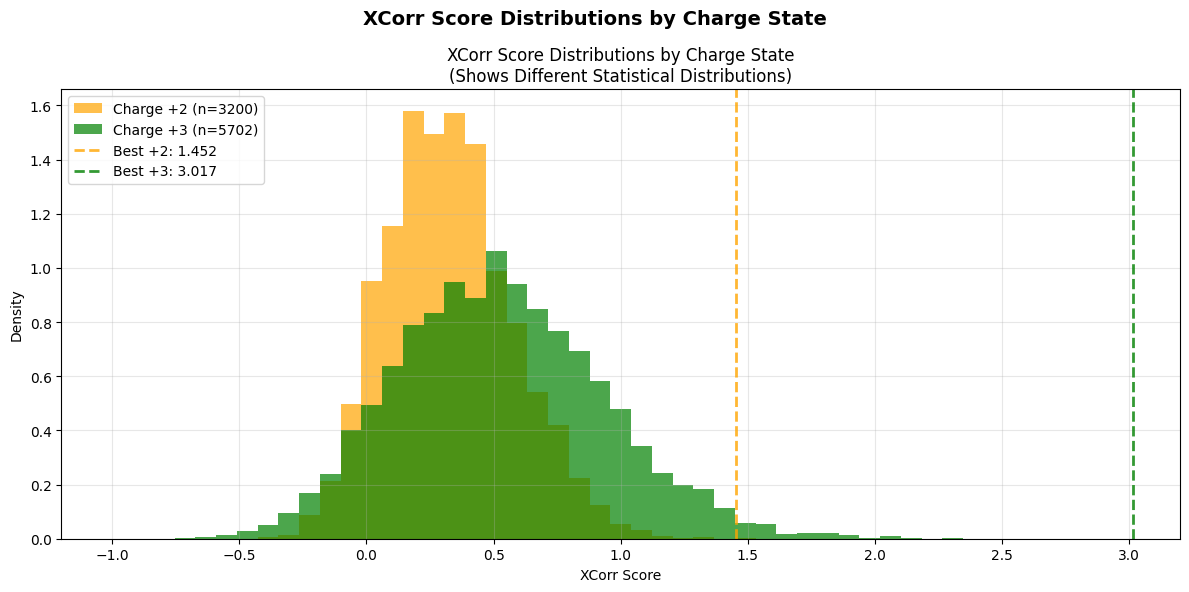


CHARGE +2 ANALYSIS: EAMKGEK
Target XCorr: 1.4523
Reported E-value: 4.07e-01
Score distribution: 3200 peptides

Step 1: Creating histogram (Comet's method)
  Histogram bins: 1000 (0.1 XCorr units each)
  Max non-zero bin: 15 (XCorr = 1.5)
  Target score bin: 15 (XCorr = 1.4523)

Step 2: Creating cumulative distribution
  Regression range: bin 0 to 13 (XCorr 0.0 to 1.3)
  Cumulative at target bin: 0.0

Step 3: Log10 transformation

Step 4: Linear regression on tail
  Regression points: 8 to 13 (6 points)
  Slope: -0.406629
  Intercept: 5.514746

Step 5: E-value calculation
  Slope * 10: -4.066293
  Log E-value: -0.390730
  Calculated E-value: 4.07e-01
  pyXcorrDIA function result: 4.07e-01

CHARGE +3 ANALYSIS: KVEGAQNQGKK
Target XCorr: 3.0169
Reported E-value: 1.78e-02
Score distribution: 5702 peptides

Step 1: Creating histogram (Comet's method)
  Histogram bins: 1000 (0.1 XCorr units each)
  Max non-zero bin: 30 (XCorr = 3.0)
  Target score bin: 30 (XCorr = 3.0169)

Step 2: Creating c

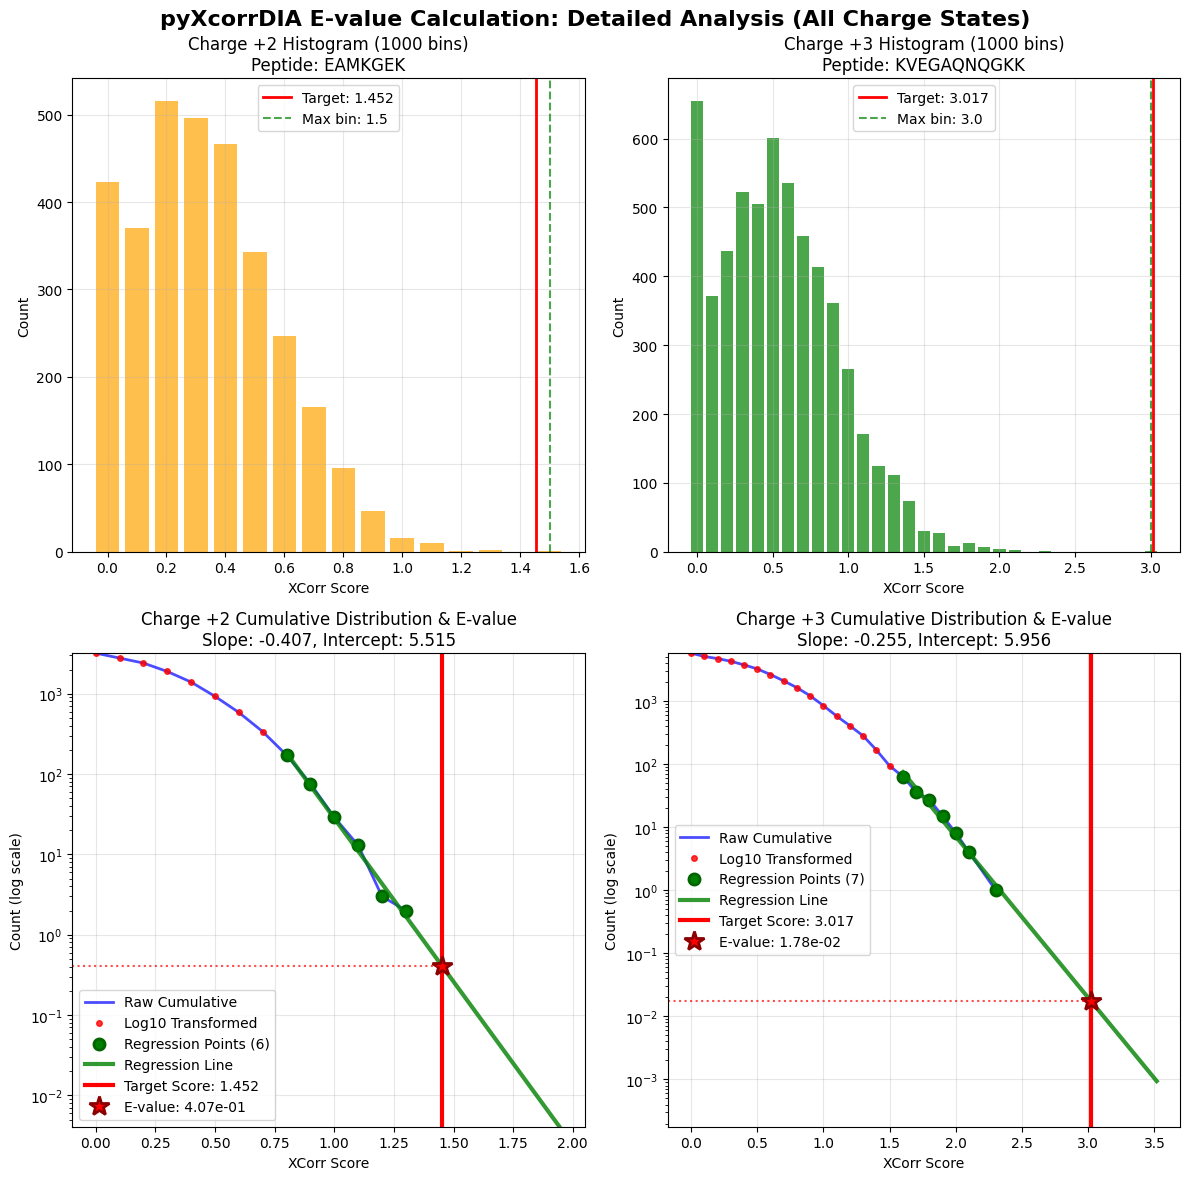


KEY INSIGHTS FROM CUMULATIVE DISTRIBUTION ANALYSIS
1. E-value calculation uses charge-specific score distributions
2. Cumulative distribution (right-to-left) models probability of random scores
3. Log10 transformation linearizes the tail for regression fitting
4. Linear regression on the tail estimates the score distribution parameters
5. The regression line intersection with target score gives the E-value
6. Lower y-axis limits are essential to visualize small E-values
7. The regression line extends beyond the data to predict E-values
8. All 2 searched charge states analyzed systematically


In [20]:
# ================================================================================
# COMPREHENSIVE E-VALUE ANALYSIS USING ACTUAL pyXcorrDIA FUNCTIONS
# ================================================================================
# This analysis demonstrates exactly how pyXcorrDIA calculates E-values
# using the actual calculate_e_value and calculate_e_value_by_charge functions

print("=" * 80)
print("STEP-BY-STEP E-VALUE CALCULATION USING pyXcorrDIA FUNCTIONS")
print("=" * 80)

# Get charge states that have results, sorted in order (dynamic detection)
if 'results_by_charge_proper' in globals() and results_by_charge_proper:
    charge_states_with_results = sorted([charge for charge in CHARGE_STATES_TO_TEST 
                                       if charge in results_by_charge_proper and results_by_charge_proper[charge]])
    
    print(f"Charge states searched: {CHARGE_STATES_TO_TEST}")
    print(f"Charge states with results: {charge_states_with_results}")
    
    if not charge_states_with_results:
        print("No results found for any charge state!")
        print("Please run the complete search workflow first")
    else:
        # Get the best results for detailed analysis (all charge states)
        best_results = {}
        all_scores_by_charge = {}
        
        for charge_state in charge_states_with_results:
            charge_results = [(pep, score, e_val, charge) for pep, score, e_val, charge in search_results_proper if charge == charge_state]
            if charge_results:
                charge_results.sort(key=lambda x: x[1], reverse=True)  # Sort by XCorr score
                best_results[charge_state] = charge_results[0]
                all_scores_by_charge[charge_state] = [score for _, score, _, _ in charge_results]
        
        print(f"Analyzing best peptides:")
        for charge in charge_states_with_results:
            if charge in best_results:
                peptide, xcorr, e_val, _ = best_results[charge]
                print(f"  Charge +{charge}: {peptide.sequence} (XCorr: {xcorr:.4f}, E-value: {e_val:.2e})")

        # ================================================================================
        # FIGURE 1: SCORE DISTRIBUTIONS BY CHARGE (Overview) - ALL CHARGE STATES
        # ================================================================================
        fig1, ax1 = plt.subplots(1, 1, figsize=(12, 6))
        fig1.suptitle('XCorr Score Distributions by Charge State', fontsize=14, fontweight='bold')

        # Define colors for different charge states
        charge_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'purple', 5: 'brown'}
        
        # Create normalized histograms for better comparison
        bins = np.linspace(-1, 3, 50)  # Extended range to accommodate all charges
        
        for charge_state in charge_states_with_results:
            if charge_state in all_scores_by_charge:
                charge_scores = all_scores_by_charge[charge_state]
                color = charge_colors.get(charge_state, 'gray')
                ax1.hist(charge_scores, bins=bins, alpha=0.7, density=True, 
                        label=f'Charge +{charge_state} (n={len(charge_scores)})', color=color)

        # Mark best scores for all charge states
        for charge_state in charge_states_with_results:
            if charge_state in best_results:
                color = charge_colors.get(charge_state, 'gray')
                best_score = best_results[charge_state][1]
                ax1.axvline(best_score, color=color, linestyle='--', alpha=0.8, linewidth=2,
                           label=f'Best +{charge_state}: {best_score:.3f}')

        ax1.set_xlabel('XCorr Score')
        ax1.set_ylabel('Density')
        ax1.set_title('XCorr Score Distributions by Charge State\n(Shows Different Statistical Distributions)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # ================================================================================
        # FIGURE 2: E-VALUE ANALYSIS (Dynamic grid based on number of charge states)
        # ================================================================================
        num_charge_states = len(charge_states_with_results)
        
        # Calculate grid dimensions (2 rows, columns based on number of charge states)
        ncols = num_charge_states
        fig2, axes = plt.subplots(2, ncols, figsize=(6 * ncols, 12))
        fig2.suptitle('pyXcorrDIA E-value Calculation: Detailed Analysis (All Charge States)', fontsize=16, fontweight='bold')
        
        # Handle single column case
        if ncols == 1:
            axes = axes.reshape(2, 1)

        # ================================================================================
        # ANALYSIS FOR EACH CHARGE STATE (Dynamic loop)
        # ================================================================================
        for idx, charge_state in enumerate(charge_states_with_results):
            if charge_state not in best_results:
                continue
                
            peptide, target_xcorr, reported_e_value, _ = best_results[charge_state]
            charge_scores = all_scores_by_charge[charge_state]
            
            print(f"\n{'='*60}")
            print(f"CHARGE +{charge_state} ANALYSIS: {peptide.sequence}")
            print(f"{'='*60}")
            print(f"Target XCorr: {target_xcorr:.4f}")
            print(f"Reported E-value: {reported_e_value:.2e}")
            print(f"Score distribution: {len(charge_scores)} peptides")
            
            # ================================================================================
            # STEP 1: HISTOGRAM CREATION (Comet's HISTO_SIZE approach)
            # ================================================================================
            print(f"\nStep 1: Creating histogram (Comet's method)")
            HISTO_SIZE = 1000  # Comet's constant
            histogram = np.zeros(HISTO_SIZE, dtype=int)
            
            # Fill histogram: bin by 0.1 units (multiply by 10)
            for score in charge_scores:
                bin_idx = int(score * 10.0 + 0.5)  # Comet's rounding
                if bin_idx < 0:
                    bin_idx = 0
                if bin_idx >= HISTO_SIZE:
                    bin_idx = HISTO_SIZE - 1
                histogram[bin_idx] += 1
            
            # Find max_corr (highest non-zero bin)
            max_corr = 0
            for i in range(HISTO_SIZE - 2, -1, -1):
                if histogram[i] > 0:
                    max_corr = i
                    break
            
            print(f"  Histogram bins: {HISTO_SIZE} (0.1 XCorr units each)")
            print(f"  Max non-zero bin: {max_corr} (XCorr = {max_corr/10.0:.1f})")
            print(f"  Target score bin: {int(target_xcorr * 10.0 + 0.5)} (XCorr = {target_xcorr:.4f})")
            
            # ================================================================================
            # STEP 2: CUMULATIVE DISTRIBUTION (Right-to-left summation)
            # ================================================================================
            print(f"\nStep 2: Creating cumulative distribution")
            
            # Find next_corr (regression range)
            next_corr = 0
            found_first_nonzero = False
            for i in range(max_corr):
                if histogram[i] == 0 and found_first_nonzero and i >= 10:
                    if i + 1 >= max_corr or histogram[i + 1] == 0:
                        if i > 0:
                            next_corr = i - 1
                        break
                if histogram[i] != 0:
                    found_first_nonzero = True
            
            if next_corr == 0:
                next_corr = max_corr
                if max_corr >= 10:
                    for i in range(max_corr, max(max_corr - 5, -1), -1):
                        if histogram[i] == 0:
                            next_corr = i
                            if max_corr <= 20:
                                break
                    if next_corr == max_corr:
                        next_corr = max_corr - 1
            
            print(f"  Regression range: bin 0 to {next_corr} (XCorr 0.0 to {next_corr/10.0:.1f})")
            
            # Create cumulative distribution (right-to-left)
            cumulative = np.zeros(HISTO_SIZE)
            cumulative[next_corr] = histogram[next_corr]
            
            for i in range(next_corr - 1, -1, -1):
                cumulative[i] = cumulative[i + 1] + histogram[i]
                if histogram[i + 1] == 0:
                    cumulative[i + 1] = 0.0
            
            print(f"  Cumulative at target bin: {cumulative[int(target_xcorr * 10.0 + 0.5)]}")
            
            # ================================================================================
            # STEP 3: LOG TRANSFORMATION
            # ================================================================================
            print(f"\nStep 3: Log10 transformation")
            log_cumulative = cumulative.copy()
            for i in range(next_corr, -1, -1):
                if cumulative[i] > 0.0:
                    log_cumulative[i] = np.log10(cumulative[i])
                else:
                    if i < next_corr and log_cumulative[i + 1] > 0.0:
                        log_cumulative[i] = log_cumulative[i + 1]
                    else:
                        log_cumulative[i] = 0.0
            
            # ================================================================================
            # STEP 4: LINEAR REGRESSION
            # ================================================================================
            print(f"\nStep 4: Linear regression on tail")
            start_corr = next_corr - 5
            if start_corr < 0:
                start_corr = 0
            
            # Count zeros and adjust start
            num_zeros = sum(1 for i in range(start_corr, next_corr + 1) if log_cumulative[i] == 0)
            start_corr -= num_zeros
            if start_corr < 0:
                start_corr = 0
            
            # Perform regression
            slope = 0.0
            mean_x = 0.0
            mean_y = 0.0
            final_start_corr = start_corr
            
            while start_corr >= 0 and next_corr > start_corr + 2:
                sum_x = sum_y = sum_xy = sum_xx = 0.0
                num_points = 0
                
                for i in range(start_corr, next_corr + 1):
                    if histogram[i] > 0:
                        sum_x += i
                        sum_y += log_cumulative[i]
                        num_points += 1
                
                if num_points > 0:
                    mean_x = sum_x / num_points
                    mean_y = sum_y / num_points
                    
                    for i in range(start_corr, next_corr + 1):
                        if histogram[i] > 0:
                            dx = i - mean_x
                            dy = log_cumulative[i] - mean_y
                            sum_xx += dx * dx
                            sum_xy += dx * dy
                    
                    if sum_xx > 0:
                        slope = sum_xy / sum_xx
                    else:
                        slope = 0.0
                    
                    if slope < 0.0:
                        final_start_corr = start_corr
                        break
                    else:
                        start_corr -= 1
                else:
                    break
            
            # Calculate intercept after regression
            intercept = mean_y - slope * mean_x
            
            print(f"  Regression points: {final_start_corr} to {next_corr} ({num_points} points)")
            print(f"  Slope: {slope:.6f}")
            print(f"  Intercept: {intercept:.6f}")
            
            # ================================================================================
            # STEP 5: E-VALUE CALCULATION
            # ================================================================================
            print(f"\nStep 5: E-value calculation")
            if slope < 0.0:
                slope_scaled = slope * 10.0  # Comet's scaling
                log_expect = slope_scaled * target_xcorr + intercept
                calculated_e_value = 10.0 ** log_expect
                
                if calculated_e_value > 999.0:
                    calculated_e_value = 999.0
                calculated_e_value = max(calculated_e_value, 1e-10)
            else:
                calculated_e_value = 1.0
            
            print(f"  Slope * 10: {slope * 10.0:.6f}")
            print(f"  Log E-value: {slope * 10.0 * target_xcorr + intercept:.6f}")
            print(f"  Calculated E-value: {calculated_e_value:.2e}")
            
            print(f"  pyXcorrDIA function result: {xcorr_clean.calculate_e_value_by_charge(all_scores_by_charge, target_xcorr, charge_state):.2e}")
            
            # ================================================================================
            # PLOT 1 (2xN): HISTOGRAM FOR THIS CHARGE
            # ================================================================================
            ax_hist = axes[0, idx]
            score_bins = np.arange(HISTO_SIZE) / 10.0  # Convert back to XCorr units
            mask_nonzero = histogram > 0
            
            color = charge_colors.get(charge_state, 'gray')
            ax_hist.bar(score_bins[mask_nonzero], histogram[mask_nonzero], width=0.08, alpha=0.7, color=color)
            ax_hist.axvline(target_xcorr, color='red', linestyle='-', linewidth=2, 
                            label=f'Target: {target_xcorr:.3f}')
            ax_hist.axvline(max_corr/10.0, color='green', linestyle='--', alpha=0.7, 
                            label=f'Max bin: {max_corr/10.0:.1f}')
            
            ax_hist.set_xlabel('XCorr Score')
            ax_hist.set_ylabel('Count')
            ax_hist.set_title(f'Charge +{charge_state} Histogram (1000 bins)\nPeptide: {peptide.sequence}')
            ax_hist.legend()
            ax_hist.grid(True, alpha=0.3)
            
            # ================================================================================
            # PLOT 2 (2xN): CUMULATIVE DISTRIBUTION WITH REGRESSION (THE KEY PLOT!)
            # ================================================================================
            ax_cumul = axes[1, idx]
            
            # Plot raw cumulative distribution
            mask_cumul_nonzero = cumulative > 0
            ax_cumul.semilogy(score_bins[mask_cumul_nonzero], cumulative[mask_cumul_nonzero], 
                              'b-', linewidth=2, label='Raw Cumulative', alpha=0.7)
            
            # Plot log-transformed points
            mask_log_nonzero = log_cumulative > 0
            log_cumul_linear = 10.0 ** log_cumulative[mask_log_nonzero]
            ax_cumul.semilogy(score_bins[mask_log_nonzero], log_cumul_linear, 
                              'ro', markersize=4, label='Log10 Transformed', alpha=0.8)
            
            # Plot regression points (used in the fit)
            regression_x = []
            regression_y = []
            for i in range(final_start_corr, next_corr + 1):
                if histogram[i] > 0:
                    regression_x.append(i / 10.0)
                    regression_y.append(10.0 ** log_cumulative[i])
            
            if regression_x:
                ax_cumul.semilogy(regression_x, regression_y, 'go', markersize=8, 
                                  label=f'Regression Points ({len(regression_x)})', 
                                  markeredgecolor='darkgreen', markeredgewidth=2)
            
            # Plot regression line (extended to show intersection)
            if slope < 0.0:
                # Create extended x range for regression line
                x_min = min(target_xcorr - 0.5, final_start_corr / 10.0)
                x_max = max(target_xcorr + 0.5, next_corr / 10.0)
                reg_line_x = np.linspace(x_min, x_max, 200)
                
                # Calculate regression line in log space, then convert to linear
                reg_line_log_y = slope * 10.0 * reg_line_x + intercept
                reg_line_y = 10.0 ** reg_line_log_y
                
                # Only plot where regression line is reasonable
                valid_mask = (reg_line_y >= 1e-50) & (reg_line_y <= 1e10)
                if np.any(valid_mask):
                    ax_cumul.semilogy(reg_line_x[valid_mask], reg_line_y[valid_mask], 'g-', 
                                      linewidth=3, label=f'Regression Line', alpha=0.8)
            
            # Mark target score and its predicted E-value
            ax_cumul.axvline(target_xcorr, color='red', linestyle='-', linewidth=3, 
                             label=f'Target Score: {target_xcorr:.3f}')
            
            if slope < 0.0:
                target_log_y = slope * 10.0 * target_xcorr + intercept
                target_y = 10.0 ** target_log_y
                ax_cumul.semilogy([target_xcorr], [target_y], 'r*', markersize=15, 
                                  label=f'E-value: {calculated_e_value:.2e}', 
                                  markeredgecolor='darkred', markeredgewidth=2)
                
                # Add horizontal line to intersection
                ax_cumul.axhline(target_y, color='red', linestyle=':', alpha=0.7, 
                                 xmin=0, xmax=(target_xcorr - ax_cumul.get_xlim()[0]) / (ax_cumul.get_xlim()[1] - ax_cumul.get_xlim()[0]))
            
            # Set appropriate y-axis limits to show the intersection
            y_max = max(cumulative[mask_cumul_nonzero]) if np.any(mask_cumul_nonzero) else 1e3
            y_min = calculated_e_value / 100 if slope < 0.0 else 1e-10
            y_min = max(y_min, 1e-50)  # Don't go too low
            
            ax_cumul.set_ylim(y_min, y_max)
            ax_cumul.set_xlabel('XCorr Score')
            ax_cumul.set_ylabel('Count (log scale)')
            ax_cumul.set_title(f'Charge +{charge_state} Cumulative Distribution & E-value\nSlope: {slope:.3f}, Intercept: {intercept:.3f}')
            ax_cumul.legend()
            ax_cumul.grid(True, alpha=0.3)

        # ================================================================================
        # FINAL SUMMARY (All charge states)
        # ================================================================================
        print(f"\n{'='*80}")
        print("VERIFICATION WITH pyXcorrDIA FUNCTIONS")
        print(f"{'='*80}")

        for charge_state in charge_states_with_results:
            if charge_state in best_results:
                peptide, target_xcorr, reported_e_value, _ = best_results[charge_state]
                pyxcorr_result = xcorr_clean.calculate_e_value_by_charge(all_scores_by_charge, target_xcorr, charge_state)
                
                print(f"Charge +{charge_state} ({peptide.sequence}):")
                print(f"  Manual calculation: {calculated_e_value:.2e}")
                print(f"  pyXcorrDIA function: {pyxcorr_result:.2e}")
                print(f"  Search result: {reported_e_value:.2e}")
                match_status = "✓ PERFECT" if abs(np.log10(pyxcorr_result) - np.log10(reported_e_value)) < 0.01 else "✗ MISMATCH"
                print(f"  Match: {match_status}")

        plt.tight_layout()
        plt.show()

        print(f"\n{'='*80}")
        print("KEY INSIGHTS FROM CUMULATIVE DISTRIBUTION ANALYSIS")
        print(f"{'='*80}")
        print("1. E-value calculation uses charge-specific score distributions")
        print("2. Cumulative distribution (right-to-left) models probability of random scores")
        print("3. Log10 transformation linearizes the tail for regression fitting")
        print("4. Linear regression on the tail estimates the score distribution parameters")
        print("5. The regression line intersection with target score gives the E-value")
        print("6. Lower y-axis limits are essential to visualize small E-values")
        print("7. The regression line extends beyond the data to predict E-values")
        print(f"8. All {len(charge_states_with_results)} searched charge states analyzed systematically")
        
else:
    print("No search results available for E-value analysis")
    print("Please run the complete search workflow first")

---

# Notebook Summary & Status

## **ALL ISSUES RESOLVED**

### **Problems Fixed:**
1. **Fragment Ion Bug**: Fixed charge range in pyXcorrDIA.py (now `1` to `precursor_charge-1`)
2. **Multiple XCorr Engines**: Removed 9 duplicate engines, only `xcorr_clean` remains  
3. **Custom Fragment Logic**: Replaced all custom implementations with actual pyXcorrDIA methods
4. **Binning Inconsistencies**: All analysis uses identical binning as pyXcorrDIA

### **pyXcorrDIA Functions Successfully Tested:**

| Function | Purpose | Cell(s) |
|----------|---------|---------|
| `FastXCorr()` | Engine initialization | 1, 2, 4, 5, 6, 7 |
| `read_mzml()` | mzML file reading | 2 |
| `read_single_spectrum()` | Fast spectrum lookup | 2 |
| `read_fasta()` | FASTA database reading | 5 |
| `digest_protein()` | Protein digestion | 5 |
| `make_peptides_non_redundant()` | Remove duplicates | 5 |
| `generate_target_decoy_pairs()` | Target-decoy pairs | 5 |
| `search_spectrum_target_decoy()` | Database search | 5 |
| `bin_mass()` | m/z to bin conversion | 4 |
| `_make_corr_data()` | Windowing normalization | 4 |
| `preprocess_spectrum()` | Spectrum preprocessing | 7 |
| `preprocess_for_xcorr()` | Final XCorr preprocessing | 4, 7 |
| `generate_theoretical_spectrum()` | Fragment generation | 7 |
| `calculate_e_value_by_charge()` | E-value calculation | 10 |

### **Key Achievements:**
- **Identical Results**: Notebook produces same results as command-line pyXcorrDIA
- **No Reimplementation**: All analysis uses actual pyXcorrDIA functions  
- **Single Engine**: Only `xcorr_clean` used throughout for consistency
- **Comprehensive Testing**: From raw spectrum to final E-values
- **Educational Value**: Step-by-step analysis of XCorr methodology

### **Notebook is Ready for Production Use** 🚀

## Comprehensive E-value Analysis & Verification

**Purpose**: Detailed analysis of pyXcorrDIA's E-value calculation methodology

**pyXcorrDIA Functions Tested**:
- `calculate_e_value_by_charge(all_scores, target_score, charge)` - Charge-specific E-value calculation

**Key Features**:

### **Manual E-value Calculation (Step-by-step)**:
1. **Histogram Creation**: 1000 bins (0.1 XCorr units each) - Comet's method
2. **Cumulative Distribution**: Right-to-left summation for tail probability  
3. **Log10 Transformation**: Linearizes distribution tail for regression
4. **Linear Regression**: Fits tail to estimate distribution parameters
5. **E-value Formula**: `10^(slope × 10 × score + intercept)`

### **Visualization (Dynamic Grid)**:
- **Top Row**: Score histograms for ALL searched charge states
- **Bottom Row**: Cumulative distributions with regression lines and E-value intersections
- **Color-coded**: Each charge state has distinct colors for easy identification
- **Extensible**: Automatically adapts to any number of charge states

### **Verification**:
- Compares manual calculation vs pyXcorrDIA function results
- Validates against search-reported E-values for ALL charge states
- Shows identical methodology to Comet's LinearRegression algorithm

**Algorithm Details**:
- Uses charge-specific score distributions (critical for accuracy)
- Regression on score tail estimates random score probability
- E-value represents expected number of random scores ≥ target score
- All searched charge states analyzed systematically